In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import time

# Convert labels to one-hot vectors

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get Mnist data and split into train validation and test

In [2]:
def get_mnist():

    data=np.float64(np.load('/project/cmsc25025/mnist/MNIST.npy'))
    print(data.shape)
    labels=np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000]
    train_labels=one_hot(np.int32(labels[0:50000]))
    val_dat=data[50000:60000]
    val_labels=one_hot(np.int32(labels[50000:60000]))
    test_dat=data[60000:70000]
    test_labels=one_hot(np.int32(labels[60000:70000]))
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

# Get CIFAR10 data and split into train validation and test

In [3]:
def get_cifar():
    tr=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10.npy'))
    tr_lb=np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:45000]/255.
    train_labels=one_hot(tr_lb[0:45000])
    val_data=tr[45000:]/255.
    val_labels=one_hot(tr_lb[45000:])
    test_data=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)



# Get transformed Mnist data

In [4]:
def get_mnist_trans():
    test_trans_dat=np.float32(np.load('/project/cmsc25025/mnist/MNIST_TEST_TRANS.npy'))
    test_labels=one_hot(np.int32(np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))))
    return (test_trans_dat, test_labels)

# Convolution layer with relu

In [5]:
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):

    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    W = tf.get_variable('W',shape=shape)/np.sqrt(3.) # Default initialization is Glorot (the one explained in the slides)
    #b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv)
    return(relu)

# Fully connected layer

In [6]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape)/np.sqrt(3.)
    #b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) #+ b_fc
    return(fc)

In [7]:
# The network. Original architecture (no biases)

In [8]:
#tf.reset_default_graph()

def create_network(x_image,y_,keep_prob):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

# Half the number of features - half as many filters in conv1, half as many units in fc1, conv2 remains the same

In [9]:
#tf.reset_default_graph()

def create_network_1(x_image,y_, keep_prob):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=16)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=128)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [10]:
# Twice the number of features - twice as many filters in conv1, twice as many units in fc1, conv2 remains the same

In [11]:
#tf.reset_default_graph()

def create_network_2(x_image,y_, keep_prob):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=64)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=512)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

# For each conv layer in previous architecture, 2 consecutive conv layers with smaller filters (3x3). Same numbers of filters.

In [12]:
#tf.reset_default_graph()

def create_network_3(x_image,y_, keep_prob):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[3, 3],num_features=32)
    with tf.variable_scope("conv1a"):
            relu1a = conv_relu_layer(relu1, filter_size=[3, 3],num_features=32)
            pool1 = tf.nn.max_pool(relu1a, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[3, 3],num_features=64)
    with tf.variable_scope("conv2a"):
            relu2a = conv_relu_layer(relu2, filter_size=[3, 3],num_features=64)
            pool2 = tf.nn.max_pool(relu2a, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

# Get loss and accuracy on a data set with output from final layer fc2

In [13]:
from scipy.special import logsumexp

def get_stats(data,labels,fc2,x,y_):
    t1=time.time()
    lo=0.
    acc=0.
    delta=1000
    rr=np.arange(0,data.shape[0],delta)
    for i in rr:
        fc2_out=fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf=logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1))-fc2_out
        lo+=np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc=acc/np.float32(len(rr))
    lo=lo/np.float32(len(rr))
    #print('get stats time',time.time()-t1)
    # We return the final functions (they contain all the information about the graph of the network)
    return lo, acc

# Run one epoch

In [14]:

# Run the iterations of one epoch
def run_epoch(train,val,ii,batch_size,train_step_new,step_size,keep_prob,x,y_,lr_,keep_prob_):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob})
        print('Epoch time',time.time()-t1)

In [15]:
def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
    elif (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="mnist_transform"):
        return(get_mnist_trans())

In [16]:
# Run the training on network `create_network'. Save the model and test at the end¶

In [17]:
# Run the training
def run_net(create_network=create_network,data_set="mnist",draw=True):
    
    batch_size=500
    step_size=.001
    num_epochs=20
    num_train=45000
    minimizer="Adam"
    model_name="model"
    keep_prob=1.
    dim=28
    nchannels=1

    create=create_network
    stats=get_stats

    if (data_set=="cifar"):
        dim=32
        nchannels=3


    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
    x_image = tf.reshape(x, [-1, dim, dim, nchannels])
    # Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
    # The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
    # We will slide filter over this 2d picture with conv2d function.
    y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
    # Allows you to control the time step during the iterations
    lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
    keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

    with tf.Session() as sess:
            train,val,test=get_data(data_set=data_set)
            # Create the network architecture with the above placeholdes as the inputs.
            cross_entropy, accuracy, fc2 =create(x_image,y_,keep_prob)

            # Define the miminization method
            if (minimizer=="Adam"):
                train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
            elif (minimizer=="SGD"):
                train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
            # Initialize variables
            sess.run(tf.global_variables_initializer())
            # Show trainable variables
            num_pars=0
            for v in tf.trainable_variables():
                num_pars+=np.prod(np.array(v.get_shape().as_list()))
                print(v.name,v.get_shape().as_list(),np.std(v.eval()))
            print('Total params',num_pars)
            ii=np.arange(0,num_train,1) #len(train_data),1)
            # Run epochs
            for i in range(num_epochs):  # number of epochs
                # Place holders need to passed along to the function they are no longer global.
                run_epoch(train,val,ii,batch_size,train_step,step_size,keep_prob,x,y_,lr_,keep_prob_)
                if (np.mod(i,1)==0):
                    # Same here with placeholders.
                    lo,ac = stats(train[0][0:num_train],train[1][0:num_train],fc2,x,y_)
                    print('Epoch',i,'Train loss, accuracy',lo,ac)
                    vlo,vac = stats(val[0],val[1],fc2,x,y_)
                    print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                    # Test set accuracy

            print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
            v=tf.trainable_variables()[0]
            W=v.eval()
            
            if (draw):
                if (data_set=="mnist"):
                    plt.figure(figsize=(16,8))
                    for i in range(W.shape[3]):
                        im=W[:,:,:,i].reshape(5,5)
                    im=(im-np.min(im))/(np.max(im)-np.min(im))
                    plt.subplot(4,8,i+1)
                    plt.imshow(im,cmap="gray")
                    plt.axis('off')
                elif (data_set=="cifar"):
                    plt.figure(figsize=(6,64))
                    t=1
                    for i in range(W.shape[3]):
                        im=W[:,:,:,i].reshape(5,5,3)
                        for c in range(3):
                            plt.subplot(32,3,t)
                            t+=1
                            plt.imshow(im[:,:,c],cmap="gray")
                            plt.axis('off')
            # Save model
            tf.add_to_collection("optimizer", train_step)
            saver = tf.train.Saver()
            save_path = saver.save(sess, "tmp/"+model_name)
            print("Model saved in path: %s" % save_path)


In [ ]:
# Running MNIST with basic architecture to show lower level filters.

(70000, 784)
(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.04976173
conv2/W:0 [5, 5, 32, 64] 0.028829087
fc1/W:0 [3136, 256] 0.024281139
fc2/W:0 [256, 10] 0.08723366
Total params 857376
Epoch time 3.070348024368286
Epoch 0 Train loss, accuracy 0.1870660586190224 0.9427000000000002
EPoch 0 Validation loss, accuracy 0.17463374711275104 0.9475999999999999
Epoch time 2.7948474884033203
Epoch 1 Train loss, accuracy 0.09643897057771682 0.9705599999999999
EPoch 1 Validation loss, accuracy 0.08699187672138213 0.9738999999999999
Epoch time 2.798830509185791
Epoch 2 Train loss, accuracy 0.07136963263034819 0.9777800000000001
EPoch 2 Validation loss, accuracy 0.0644684206843376 0.9773
Epoch time 4.141128063201904
Epoch 3 Train loss, accuracy 0.056269887034893024 0.9829399999999996
EPoch 3 Validation loss, accuracy 0.051214538979530336 0.9838999999999999
Epoch time 2.8094210624694824
Epoch 4 Train loss, accuracy 0.042700421957969664 0.9870999999999998
EPoch 4 Validation loss, accuracy 0.04147955963611603

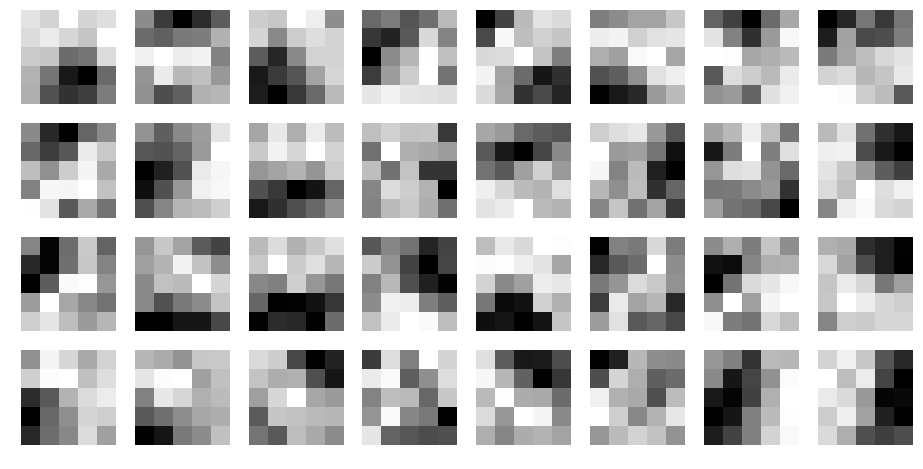

In [60]:
run_net(create_network,data_set="mnist")

# Run base network on CIFAR10 images. At the end show the Red, green and blue channels of all 32 filters.

conv1/W:0 [5, 5, 3, 32] 0.047248516
conv2/W:0 [5, 5, 32, 64] 0.028832799
fc1/W:0 [4096, 256] 0.021444997
fc2/W:0 [256, 10] 0.08723276
Total params 1104736
Epoch time 3.508297920227051
Epoch 0 Train loss, accuracy 1.6459719382656943 0.41248888888888907
EPoch 0 Validation loss, accuracy 1.6435893629312517 0.41179999999999994
Epoch time 3.2815494537353516
Epoch 1 Train loss, accuracy 1.4353472941478094 0.4955333333333333
EPoch 1 Validation loss, accuracy 1.4376005763292314 0.492
Epoch time 3.2784512042999268
Epoch 2 Train loss, accuracy 1.3417468444426854 0.5268888888888891
EPoch 2 Validation loss, accuracy 1.3512494900941847 0.522
Epoch time 3.2828285694122314
Epoch 3 Train loss, accuracy 1.2872168014473386 0.5410444444444445
EPoch 3 Validation loss, accuracy 1.288596516251564 0.539
Epoch time 3.2844161987304688
Epoch 4 Train loss, accuracy 1.2122804423146776 0.5772444444444444
EPoch 4 Validation loss, accuracy 1.232036431002617 0.5708
Epoch time 3.3178956508636475
Epoch 5 Train loss, ac

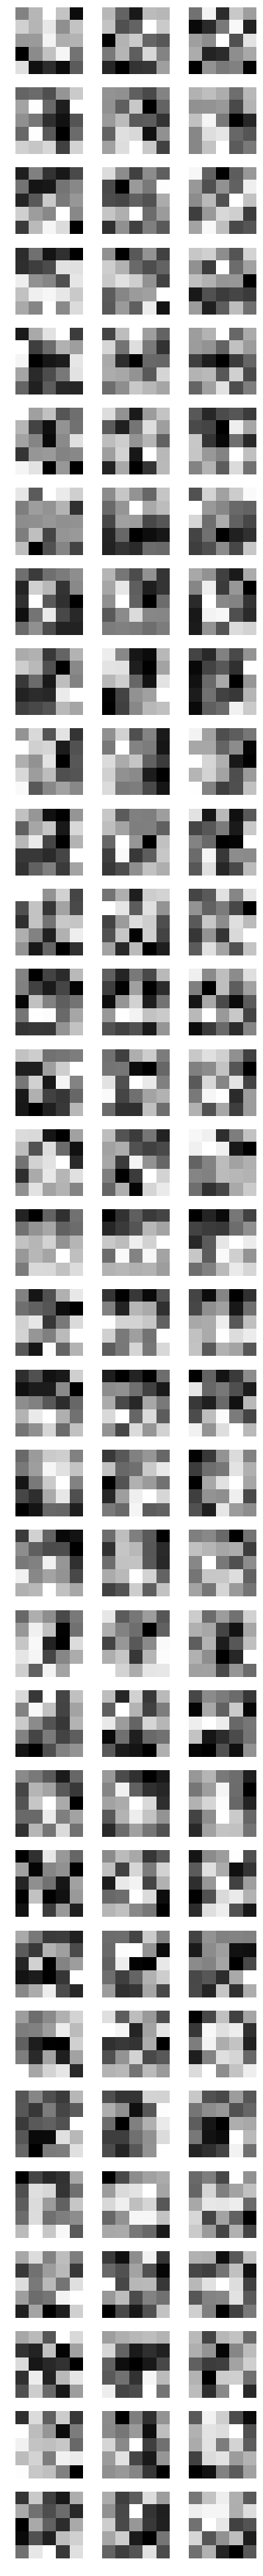

In [70]:
run_net(create_network,data_set="cifar")

# Run half the number of parameters on CIFAR10 images. 

In [18]:
run_net(create_network_1,data_set="cifar",draw=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

conv1/W:0 [5, 5, 3, 16] 0.06596251
conv2/W:0 [5, 5, 16, 64] 0.031592615
fc1/W:0 [4096, 128] 0.021771511
fc2/W:0 [128, 10] 0.11973144
Total params 552368
Epoch time 3.759420394897461
Epoch 0 Train loss, accuracy 1.676028780118624 0.40853333333333325
EPoch 0 Validation loss, accuracy 1.678031587743759 0.4006
Epoch time 2.6100049018859863
Epoch 1 Train loss, accuracy 1.5195959856642616 0.45655555555555566
EPoch 1 Validation loss, accuracy 1.5281542422533037 0.453
Epoch time 2.6661999225616455
Epoch 2 Train loss, accuracy 1.4017727389600543 0.5079777777777779
EPoch 2 Validation loss, accuracy 1.4023621407747267 0.506
Epoch time 2.5859899520874023
Epoch 3 Train loss, accuracy 1.3321895849333871 0.5307555555555558
EPoch 3 Validation loss, accuracy 1.3329665858268738 0.5298
Epoch time 2.6222598552703857


# Run twice the number of parameters on CIFAR10 images. 

In [19]:
run_net(create_network_2,data_set="cifar",draw=False)

conv1/W:0 [5, 5, 3, 64] 0.0346007
conv2/W:0 [5, 5, 64, 64] 0.02499464
fc1/W:0 [4096, 512] 0.020831903
fc2/W:0 [512, 10] 0.062204562
Total params 2209472
Epoch time 5.467350721359253
Epoch 0 Train loss, accuracy 1.593530251420869 0.433688888888889
EPoch 0 Validation loss, accuracy 1.6010676929473877 0.4338
Epoch time 4.867661237716675
Epoch 1 Train loss, accuracy 1.420520610666275 0.4948666666666666
EPoch 1 Validation loss, accuracy 1.4246627110958099 0.497
Epoch time 4.829834461212158
Epoch 2 Train loss, accuracy 1.3040031701299883 0.5447333333333333
EPoch 2 Validation loss, accuracy 1.3159491525173188 0.5456
Epoch time 4.819650411605835
Epoch 3 Train loss, accuracy 1.1806956511206101 0.5824222222222222
EPoch 3 Validation loss, accuracy 1.2057365417480468 0.5706
Epoch time 4.823241710662842
Epoch 4 Train loss, accuracy 1.0988722954140768 0.6122444444444445
EPoch 4 Validation loss, accuracy 1.1236781484127045 0.6102000000000001
Epoch time 4.840301513671875
Epoch 5 Train loss, accuracy 1

In [ ]:
# Run deeper network with same number of parameters on CIFAR10 images. Each conv layer has 3x3 filter 

In [20]:
run_net(create_network_3,data_set="cifar", draw=False)

conv1/W:0 [3, 3, 3, 32] 0.07869417
conv1a/W:0 [3, 3, 32, 32] 0.05894272
conv2/W:0 [3, 3, 32, 64] 0.048072267
conv2a/W:0 [3, 3, 64, 64] 0.04167408
fc1/W:0 [4096, 256] 0.021423034
fc2/W:0 [256, 10] 0.088785596
Total params 1116512
Epoch time 5.736936807632446
Epoch 0 Train loss, accuracy 1.649927035866843 0.40493333333333326
EPoch 0 Validation loss, accuracy 1.6530010924816132 0.40259999999999996
Epoch time 5.027634143829346
Epoch 1 Train loss, accuracy 1.5247669275707667 0.4585333333333334
EPoch 1 Validation loss, accuracy 1.5321210549831392 0.45380000000000004
Epoch time 5.029931306838989
Epoch 2 Train loss, accuracy 1.3771851545784208 0.5105111111111111
EPoch 2 Validation loss, accuracy 1.392206236886978 0.5004
Epoch time 5.033554315567017
Epoch 3 Train loss, accuracy 1.2982385531160565 0.5383777777777777
EPoch 3 Validation loss, accuracy 1.3140843524456025 0.5292
Epoch time 5.038894891738892
Epoch 4 Train loss, accuracy 1.2006401196135417 0.5807555555555556
EPoch 4 Validation loss, a